In [239]:
%matplotlib notebook
import math
import os
import numpy as np
import sympy as sym
from matplotlib import rc
import matplotlib.pyplot as plt
from scipy.stats import chi2
from IPython.display import display, Math, Markdown
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)

> ## Tarea de Estadística: Capítulos #6 y #8 del libro.

**Hecho por:** Thomas Andrade Hernández.

---

En el presente documento se desarrollan las actividades del libro _Measurements and Their Uncertainties: A Practical Guide to Modern Error Analysis - Ifan Hughes, Thomas Hase_. No se hará referencia a las tablas de información, ni a las ecuaciones que se mencionan en los enunciados a menos de que sea necesario.

In [280]:
def Linear(X, a, b):
    return a*X + b

# Código para el weighted least-squares fit:

def Delta(x, errors):
    weight = 1/(errors)**2
    
    suma_1 = 0
    suma_2 = 0
    suma_3 = 0
    
    for i in range(0, len(weight)):
        suma_1 += weight[i]
        suma_2 += weight[i] * (x[i])**2
        suma_3 += weight[i] * x[i]
    
    delta = suma_1 * suma_2 - (suma_3)**2
    return weight, delta, suma_1, suma_2, suma_3

def Parameters(x, y, errors):
    weight, delta, suma_1, suma_2, suma_3 = Delta(x, errors)
    suma_4 = 0
    suma_5 = 0
    for i in range(0, len(x)):
        suma_4 += weight[i]*y[i]
        suma_5 += weight[i]*x[i]*y[i]
        
    m = ((suma_1 * suma_5) - (suma_3 * suma_4))/delta
    c = ((suma_2 * suma_4) - (suma_3 * suma_5))/delta
    uncm = np.sqrt(suma_1/delta)
    uncc = np.sqrt(suma_2/delta)
    
    return (m, uncm), (c, uncc)

# Código de reporte de errores:

def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

def Computation_Error(expression, symbols, parameters):
    error_2 = 0.
    ward = int((len(symbols)/2))
    func_value = sym.lambdify(symbols[0:ward], expression)
    value = func_value(*parameters[0:ward])

    for i in range(0, len(symbols[0:ward])):
        unc_ward = ward + i
        error_2 += sym.diff(expression, symbols[i])**2 * (symbols[unc_ward])**2

    func_error_2 = sym.lambdify(symbols, error_2)
    value_error_2 = func_error_2(*parameters)
    
    error = np.sqrt(value_error_2)
    
    value, error = Error(value, error)
    
    return value, error

# La estadística de Durbin Watson será:

def Residuals(x, y, errors, m, c):
    y_res = np.array([])
    residuals = np.array([])
    
    for i in range(0, len(x)):
        y_res = np.append(y_res, m*x[i] - c)
    
    for i in range(0, len(y_res)):
        residuals = np.append(residuals, (y[i] - y_res[i])/errors[i])
    
    return residuals

def Durbin_Watson(residuals):
    suma_1 = 0
    suma_2 = 0
    
    for i in range(1, len(residuals)):
        suma_1 += (residuals[i] - residuals[i - 1])**2
    for i in range(0, len(residuals)):
        suma_2 += residuals[i]**2
    
    dw = suma_1/suma_2
    return dw

def ChiSquared(x, y, errors, m, c):
    chi = 0
    for i in range(0, len(x)):
        chi += ((y[i] - (m*x[i] + c))**2)/errors[i]
    return chi

def ChiSquaredDiscrete(Events, Expected):
    chidiscrete = 0
    for i in range(0, len(Events)):
        chidiscrete += (Expected[i] - Events[i])**2/Expected[i]
    return chidiscrete

---

> **Capítulo #6: Least-squares fitting of complex functions.**

---

**(6.2) Linear Regression - Weigthed fit:** For the data set of Exercise (6.1) use the results of eqns (6.3)–(6.6) to calculate the best-fit gradient and intercept using a weighted fit. Verify that the results are in agreement with Table 6.1. Draw the lag plot, and calculate the Durbin–Watson statistic $\mathcal{D}$.

In [241]:
Frequency = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]) # Hz
Voltage = np.array([16, 45, 64, 75, 70, 115, 142, 167, 183, 160, 221]) # mV
V_Error = np.array([5, 5, 5, 5, 30, 5, 5, 5, 5, 30, 5]) # mV

Gradient, Intercept = Parameters(Frequency, Voltage, V_Error)
print(Gradient)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

(2.0284648216102745, 0.051978308277218006)


In [242]:
display(Markdown("El valor de la pendiente es de ${} \pm {}$ mV/Hz, mientras que el intercepto es ${} \pm {}$ mV. Estos valores concuerdan exactamente con los reportados en el libro.".format(Gradient[0], Gradient[1], Intercept[0], Intercept[1])))

El valor de la pendiente es de $2.03 \pm 0.05$ mV/Hz, mientras que el intercepto es $-1.0 \pm 3.0$ mV. Estos valores concuerdan exactamente con los reportados en el libro.

<IPython.core.display.Javascript object>


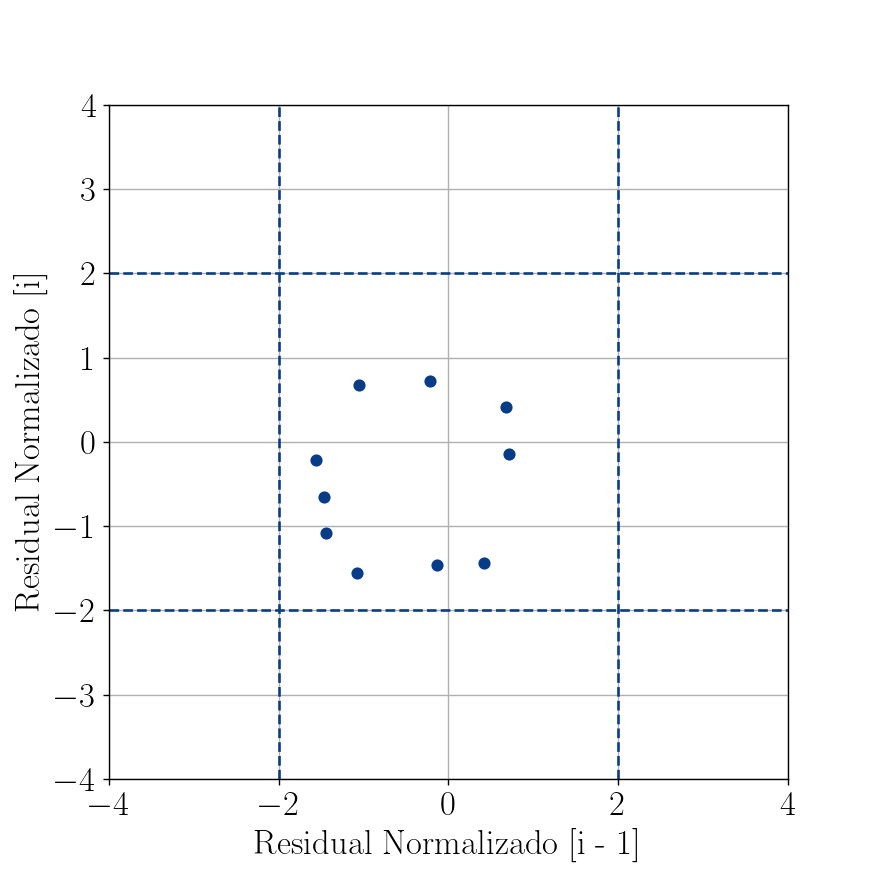

In [243]:
NormRes = Residuals(Frequency, Voltage, V_Error, Gradient[0], Intercept[0])

plt.figure(figsize = (7, 7))

# Cuadrado delimitante que encierra una región de +/- 2 sigmas.
plt.axhline(2, linestyle = "--", color = "#083c87")
plt.axvline(2, linestyle = "--", color = "#083c87")
plt.axhline(-2, linestyle = "--", color = "#083c87")
plt.axvline(-2, linestyle = "--", color = "#083c87")
plt.axis([-4, 4, -4, 4])

# Lag plot principal.
plt.xlabel("Residual Normalizado [i - 1]")
plt.ylabel("Residual Normalizado [i]")
plt.scatter(NormRes[0:len(NormRes) - 1], NormRes[1:], color = "#083c87")
plt.grid(True)

In [244]:
D_Watson = Durbin_Watson(NormRes)
display(Markdown("La estadística de Durbin Watson, $\mathcal D$, es igual a {}. Estevalor se encuentra en al región que describe un comportamiento aleatorio que sigue una distribución Gaussiana. Este resultado se justifica con la gráfica anterior, estos residuales están dentro de dicha región.".format(D_Watson)))

La estadística de Durbin Watson, $\mathcal D$, es igual a 1.1999238070518277. Estevalor se encuentra en al región que describe un comportamiento aleatorio que sigue una distribución Gaussiana. Este resultado se justifica con la gráfica anterior, estos residuales están dentro de dicha región.

---

**(6.3) Normalised Residuals:** Use the fit parameters from the last question to plot the best-fit straight line with the data. Use eqn (6.8) to calculate the normalised residuals, and plot them.

In [245]:
Frequency_ = np.linspace(min(Frequency), max(Frequency), 100)
Voltage_ = Linear(Frequency_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


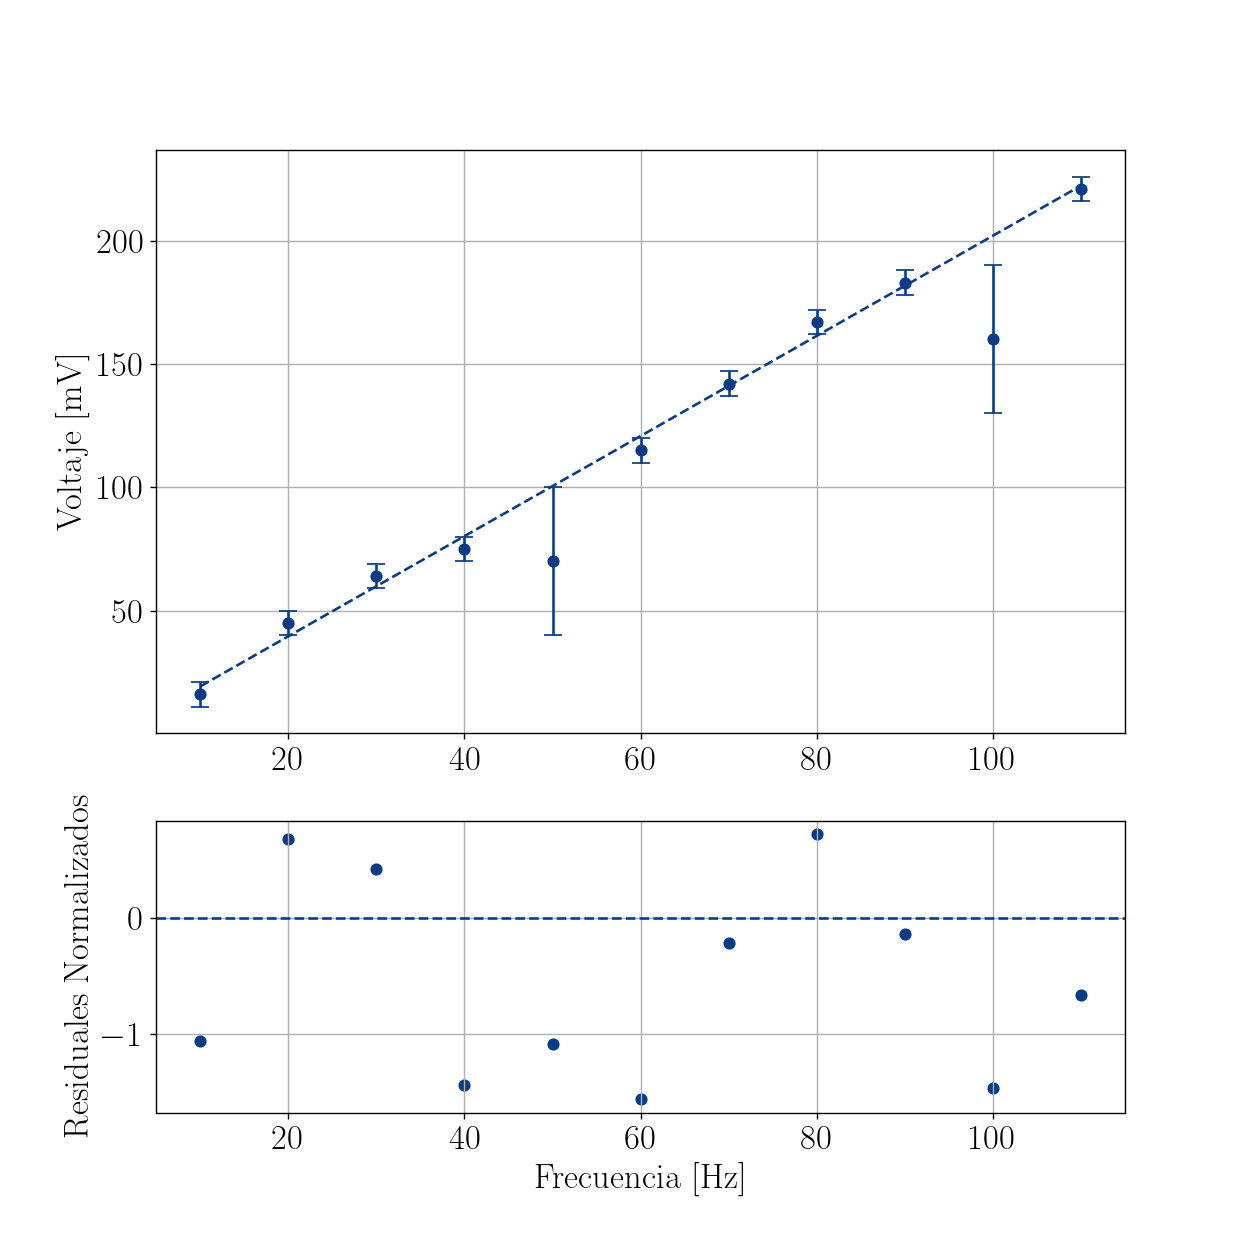

In [246]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(Frequency, Voltage, yerr = V_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(Frequency_, Voltage_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"Voltaje [mV]")
axis[0].grid(True)

axis[1].set_xlabel(r"Frecuencia [Hz]")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(Frequency, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

---

**(6.4) Error bars from a $\chi^{2}$ minimisation:** **(i)** For the data set of Exercise (6.1), write a spreadsheet which you can use to perform a $\chi^{2}$ minimisation. Verify that $\chi^{2}_{\text{min}}$ is obtained for the same values of the parameters as are listed in Table 6.1.

---

Hoja de cálculo realizada para la determinación del gradiente e intercepto que minimizan $\chi^{2}$:

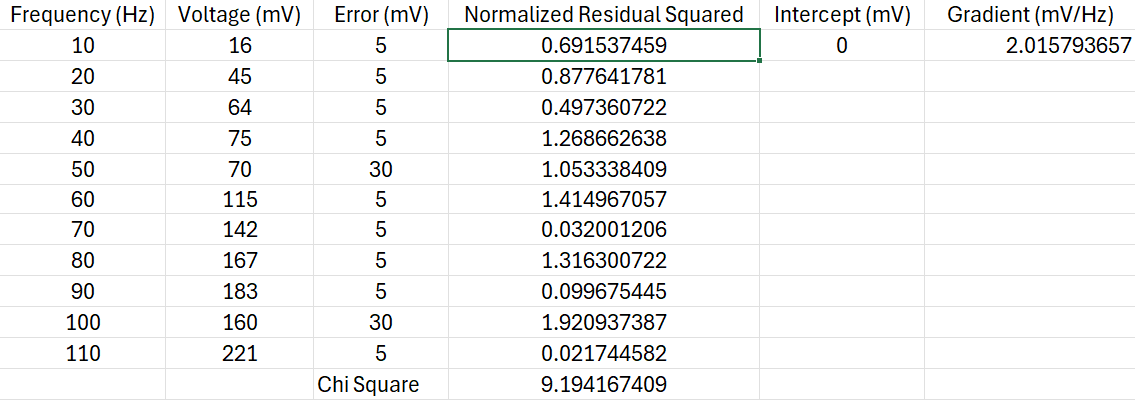

---

**(ii)** By following the procedure of $\chi^{2} \to \chi^{2}_{\text{min}} + 1$ outlined in Section **6.5**, check that the error bars for $m$ and $c$ are in agreement with Table 6.1. Let the parameters **(a)** increase from their optimal values to find the extremum for each parameter, and **(b)** decrease from their optimal values to find the extremum for each parameter. Are the uncertainties determined in **(a)** and **(b)** the same?

---

Haciendo uso de la herramienta Solver, en Excel, los valores que me proveyó para el gradiente $m$ y el intercepto $c$ son:

$$\bar{m} = 2.015793657 \text{ mV/Hz} \quad \quad \text{ y } \quad \quad \bar{c} = 0 \text{ mV}$$

Si se busca el error de estas cantidades, buscamos los valores que hacen que se desplace el $\chi^{2}$ una unidad, en cada una de las constantes. Para el primer caso, con el gradiente, el valor que incrementa $\chi^{2}$ en una unidad es $\bar{m}^{+}_{\chi^{2}_{\text{min}} + 1} \approx 2.0413$, lo que da un error de:

$$\alpha^{+}_{m} = 2.0413 - 2.015793657 = 0.025506343 \Rightarrow \alpha_{m} = 0.03 \text{ mV/Hz}$$

Mientras que, para el intercepto, el valor que incrementa $\chi^{2}$ en una unidad es $\bar{c}^{+}_{\chi^{2}_{\text{min}} + 1} \approx 1.45$ lo que da un error de:

$$\alpha^{+}_{c} = 1.45 - 0 = 1.45 \Rightarrow \alpha_{c} = 1.5 \text{ mV}$$

Estos errores discrepan en sobremanera con los reportados en el libro de $\alpha_m = 0.05$ mV/Hz y $\alpha_c = 3$, esto se debe a que el punto de partida de los valores, es decir, $\bar{m}$ y $\bar{c}$, es muy diferente. 

---

Ahora bien, realicemos una comparación con un cálculo similar, sólo que en este caso se disminuirán los valores de $\bar{m}$ y $\bar{c}$. Para $\bar{m}$, el valor que incrementa a $\chi^{2}$ a una unidad por izquierda es $\bar{m}^{-}_{\chi^{2}_{\text{min}} + 1} \approx 1.990299$, lo que da un error de:

$$\alpha^{+}_{m} = 2.015793657 - 1.990299 = 0.025494657 \Rightarrow \alpha_{m} = 0.03 \text{ mV/Hz}$$

Mientras que, para el intercepto, el valor que incrementa $\chi^{2}$ en una unidad por izquierda es $\bar{c}^{-}_{\chi^{2}_{\text{min}} + 1} \approx -1.909$ lo que da un error de:

$$\alpha^{+}_{c} = 0 - (-1.909) = 1.909 \Rightarrow \alpha_{c} = 2 \text{ mV}$$

Se logra apreciar que los errores encontrados son los muy cercanos tanto por izquierda (reduciendo valores) como por derecha (incrementando los valores). Omitiendo las discrepancias para el intercepto $\bar{c}$, es posible afirmar que los errores se distribuyen de una forma uniforme en cada uno de los ejes del mapa formado por los valores de $m$ y $c$.

---

**(iii)** Calculate the uncertainties on $m$ and $c$ by finding the extrema of the $\chi^{2} \to \chi^{2}_{\text{min}} + 4$ and $\chi^{2} \to \chi^{2}_{\text{min}} + 9$ contours. Are your results in agreement with Table 6.2?

Para este inciso se espera que los resultados de $\Delta\chi^{2} = 4$ y $\Delta\chi^{2} = 9$ correspondan a errores de $2$ y $3$ $\sigma$ aproximadamente. Veamos el caso del gradiente $\bar{m}$, donde el valor obtenido para el contorno $\Delta{\chi^{2}} = 4$ es de $m = 2.066799$, mientras que para el contorno $\Delta{\chi^{2}} = 9$ el valor es de $m = 2.09229$. Estos valores generan errores de:

$$\alpha^{\Delta\chi^{2} = 4}_{m} = 2.066799 - 2.015793657 = 0.051005343 \Rightarrow \alpha^{\Delta\chi^{2} = 4}_{m} = 0.05 \approx 1.67\alpha_{c}$$

$$\alpha^{\Delta\chi^{2} = 9}_{m} = 2.09229 - 2.015793657 = 0.076496343 \Rightarrow \alpha^{\Delta\chi^{2} = 4}_{m} = 0.08 \approx 2.67\alpha_{c}$$

---

Para el caso del intercepto $\bar{c}$, el valor obtenido para el contorno $\Delta{\chi^{2}} = 4$ es de $c = 3.1029$, mientras que para el contorno $\Delta{\chi^{2}} = 9$ el valor es de $c = 4.762$. Estos valores generan errores de:

$$\alpha^{\Delta\chi^{2} = 4}_{c} = 3.1029 - 0 = 3.1029 \Rightarrow \alpha^{\Delta\chi^{2} = 4}_{c} = 3.1 \approx 2\alpha_{c}$$

$$\alpha^{\Delta\chi^{2} = 9}_{c} = 4.762 - 0 = 4.762 \Rightarrow \alpha^{\Delta\chi^{2} = 4}_{c} = 3.1 \approx 3.2\alpha_{c}$$

---

Como conclusión general, para el caso del gradiente, el estimado calculado resulta ser algo bajo con respecto a las predicciones teóricas. No obstante, para el caso del intercepto las estimaciones se acercaban mucho más a los valores esperados. Estas discrepancias significativas son consecuencia directa de no partir de los mismos valores proporcionados por los ejemplos del libro.

**(6.5) Speed of light:** (Using the data of Fig 6.1(c)) The speed of light is related to the slope, $m$, of this graph via the relationship speed of light $= \frac{2\pi\times 60 \times 10^{6}}{m}$ Hz. Calculate the slope and intercept of the best fit straight line to the data, and their associated errors. Hence deduce the speed of light, and its error. The theoretical predication is that the intercept should be zero. Is this consistent with the data?

In [247]:
Displacement = np.array([0.05, 0.25, 0.45, 0.65, 0.85, 1.05, 1.25, 1.45, 1.65, 1.85]) # m
Phase = np.array([0.00, 0.21, 0.44, 0.67, 0.88, 1.1, 1.3, 1.5, 2.0, 2.24]) # rad
P_Error = np.array([0.05, 0.05, 0.05, 0.05, 0.09, 0.1, 0.2, 0.5, 0.1, 0.07]) # rad

Gradient, Intercept = Parameters(Displacement, Phase, P_Error)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

In [248]:
NormRes = Residuals(Displacement, Phase, P_Error, Gradient[0], Intercept[0])
Displacement_ = np.linspace(min(Displacement), max(Displacement), 100)
Phase_ = Linear(Displacement_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


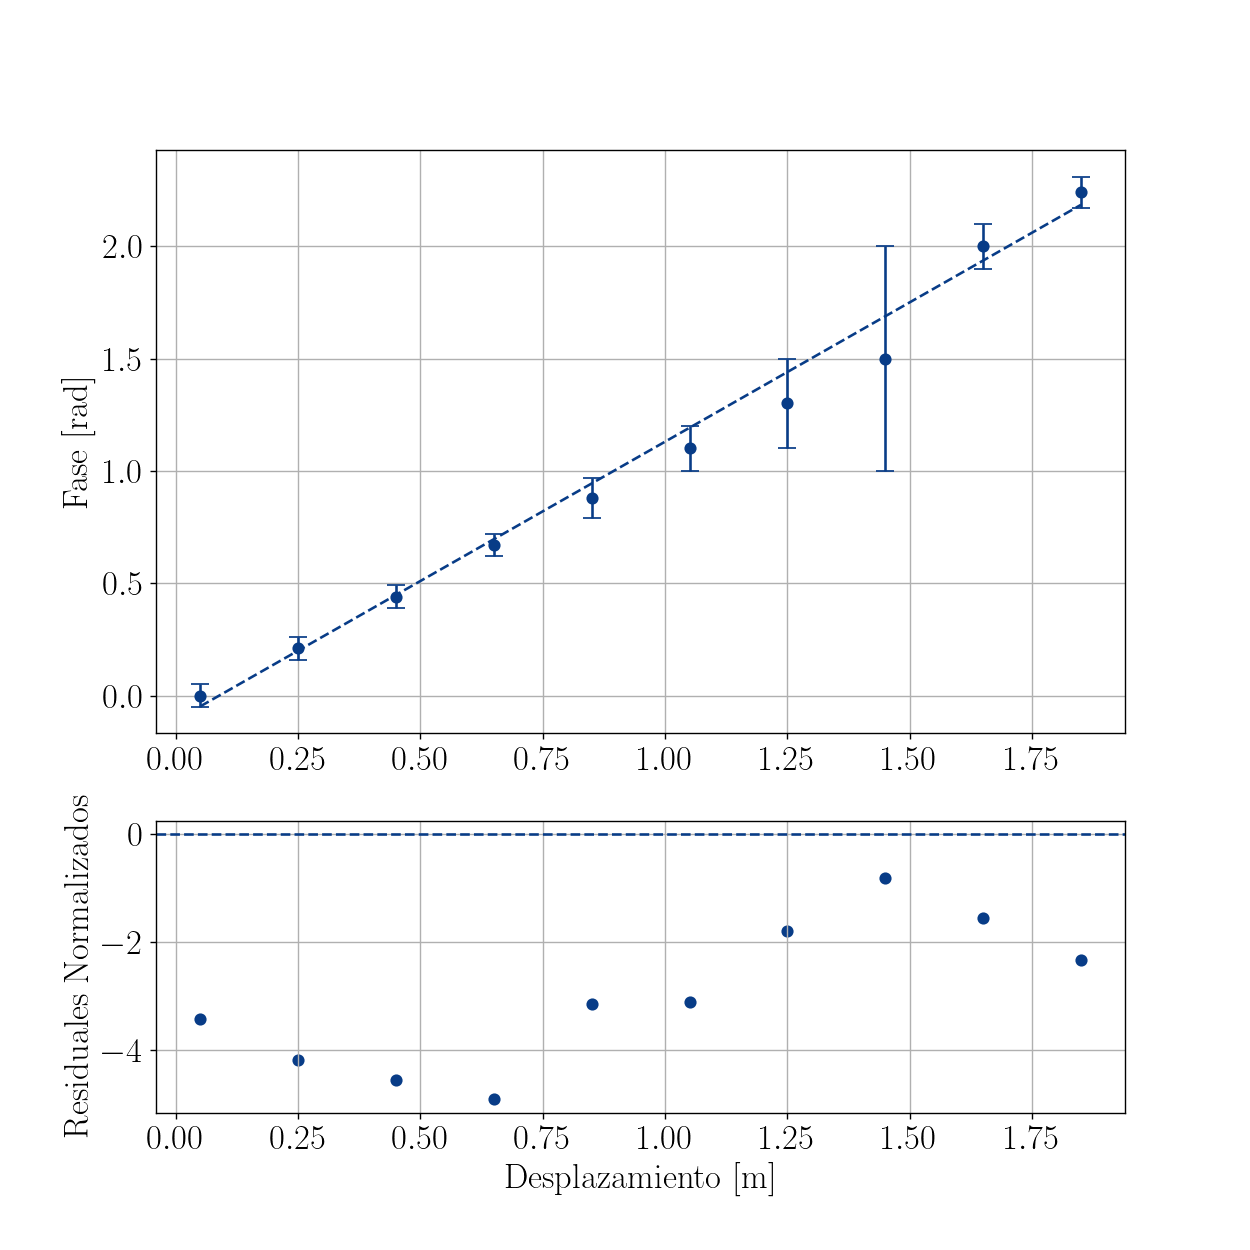

In [249]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(Displacement, Phase, yerr = P_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(Displacement_, Phase_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"Fase [rad]")
axis[0].grid(True)

axis[1].set_xlabel(r"Desplazamiento [m]")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(Displacement, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

In [250]:
m, uncm = sym.symbols("m, sigma_m", real = True)
light_sym = m, uncm
light_exp = (2*np.pi*60*1e6)/m

light_param = (Gradient[0], Gradient[1])
speed, unc_speed = Computation_Error(light_exp, light_sym, light_param)

In [251]:
display(Markdown("El valor de la velocidad de la luz calculado es de $3.0 \pm 0.1$ m/s$^2$. Por otro lado, el intercepto obtenido fue de ${} \pm {}$ rad, un valor muy cercano a cero y, por tanto, consistente con los valores esperados teóricamente.".format(Intercept[0], Intercept[1])))

El valor de la velocidad de la luz calculado es de $3.0 \pm 0.1$ m/s$^2$. Por otro lado, el intercepto obtenido fue de $-0.11 \pm 0.03$ rad, un valor muy cercano a cero y, por tanto, consistente con los valores esperados teóricamente.

In [252]:
Chi_6 = ChiSquared(Displacement, Phase, P_Error,Gradient[0], Intercept[0])

---

**(6.6) Strategies for error bars:** Using the data in the listed table: **(i)** Calculate the weighted best-fit values of the slope, intercept and their uncertainties.

---

Haciendo uso de los errores que se proporcionan, las cantidades obtenidas para la pendiente e intercepto son:

In [253]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([51, 103, 150, 199, 251, 303, 347, 398, 452, 512])
y_Error = np.array([1, 1, 2, 2, 3, 3, 4, 5, 6, 7])

Gradient, Intercept = Parameters(x, y, y_Error)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

In [254]:
NormRes = Residuals(x, y, y_Error, Gradient[0], Intercept[0])
x_ = np.linspace(min(x), max(x), 100)
y_ = Linear(x_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


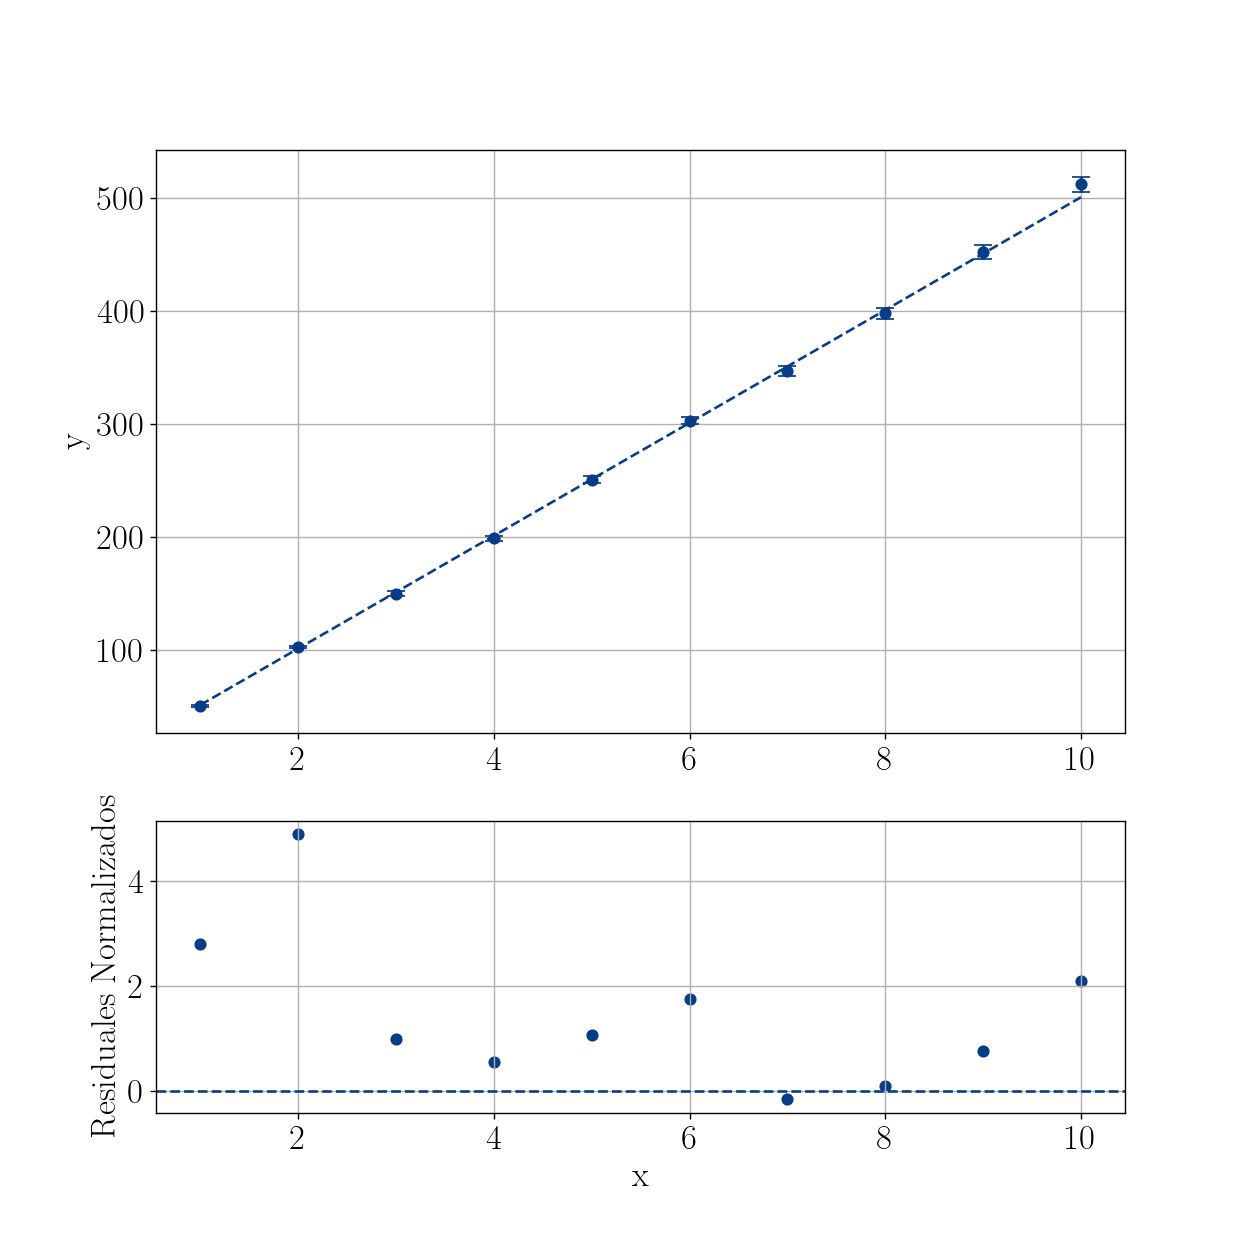

In [255]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(x, y, yerr = y_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(x_, y_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"y")
axis[0].grid(True)

axis[1].set_xlabel(r"x")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(x, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

In [256]:
display(Markdown("El valor obtenido para la pendiente es de ${} \pm {}$, mientras que para el intercepto es de ${} \pm {}$.".format(Gradient[0], Gradient[1], Intercept[0], Intercept[1])))

El valor obtenido para la pendiente es de $49.9 \pm 0.3$, mientras que para el intercepto es de $1.7 \pm 1.0$.

---

**(ii)** If the data set had been homoscedastic, with all the errors equal, $\alpha_{y} = 4$, calculate the weighted best-fit values of the slope, intercept and their uncertainties. 

Al cambiar los valores de error se obtiene:

In [257]:
y_Error = np.array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Gradient, Intercept = Parameters(x, y, y_Error)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

In [258]:
NormRes = Residuals(x, y, y_Error, Gradient[0], Intercept[0])
x_ = np.linspace(min(x), max(x), 100)
y_ = Linear(x_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


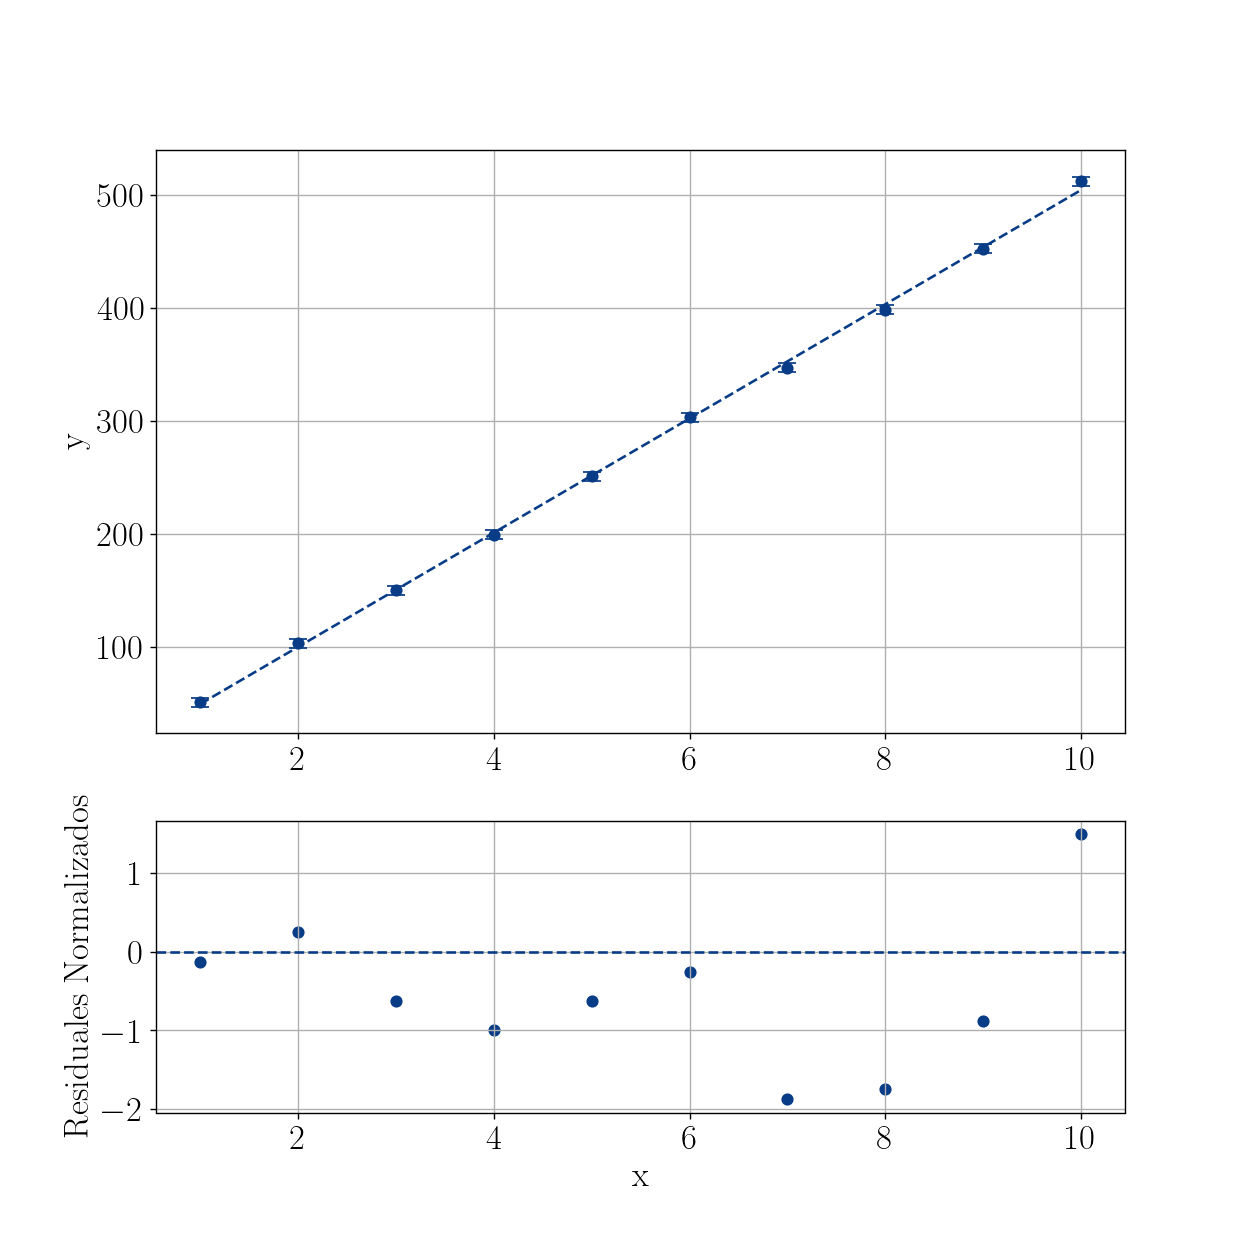

In [259]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(x, y, yerr = y_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(x_, y_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"y")
axis[0].grid(True)

axis[1].set_xlabel(r"x")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(x, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

In [260]:
display(Markdown("El valor obtenido para la pendiente es de ${} \pm {}$, mientras que para el intercepto es de ${} \pm {}$. Como se logra apreciar, las discrepancias entre los valores calculados previamente y estos es considerablemente alta, esto porque los errores en las mediciones se reparten de una forma mucho más uniforme.".format(Gradient[0], Gradient[1], Intercept[0], Intercept[1])))

El valor obtenido para la pendiente es de $50.5 \pm 0.4$, mientras que para el intercepto es de $-1.0 \pm 3.0$. Como se logra apreciar, las discrepancias entre los valores calculados previamente y estos es considerablemente alta, esto porque los errores en las mediciones se reparten de una forma mucho más uniforme.

**(iii)** If the experimenter took greater time to collect the first and last data points, for which $\alpha_{y} = 1$, at the expense of all of the other data points, for which $\alpha_{y} = 8$, calculate the weighted best-fit values of the slope, intercept and their uncertainties, and comment on your results.

---

La nueva distribución de errores será:

In [261]:
y_Error = np.array([1, 8, 8, 8, 8, 8, 8, 8, 8, 1])

Gradient, Intercept = Parameters(x, y, y_Error)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

In [262]:
NormRes = Residuals(x, y, y_Error, Gradient[0], Intercept[0])
x_ = np.linspace(min(x), max(x), 100)
y_ = Linear(x_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


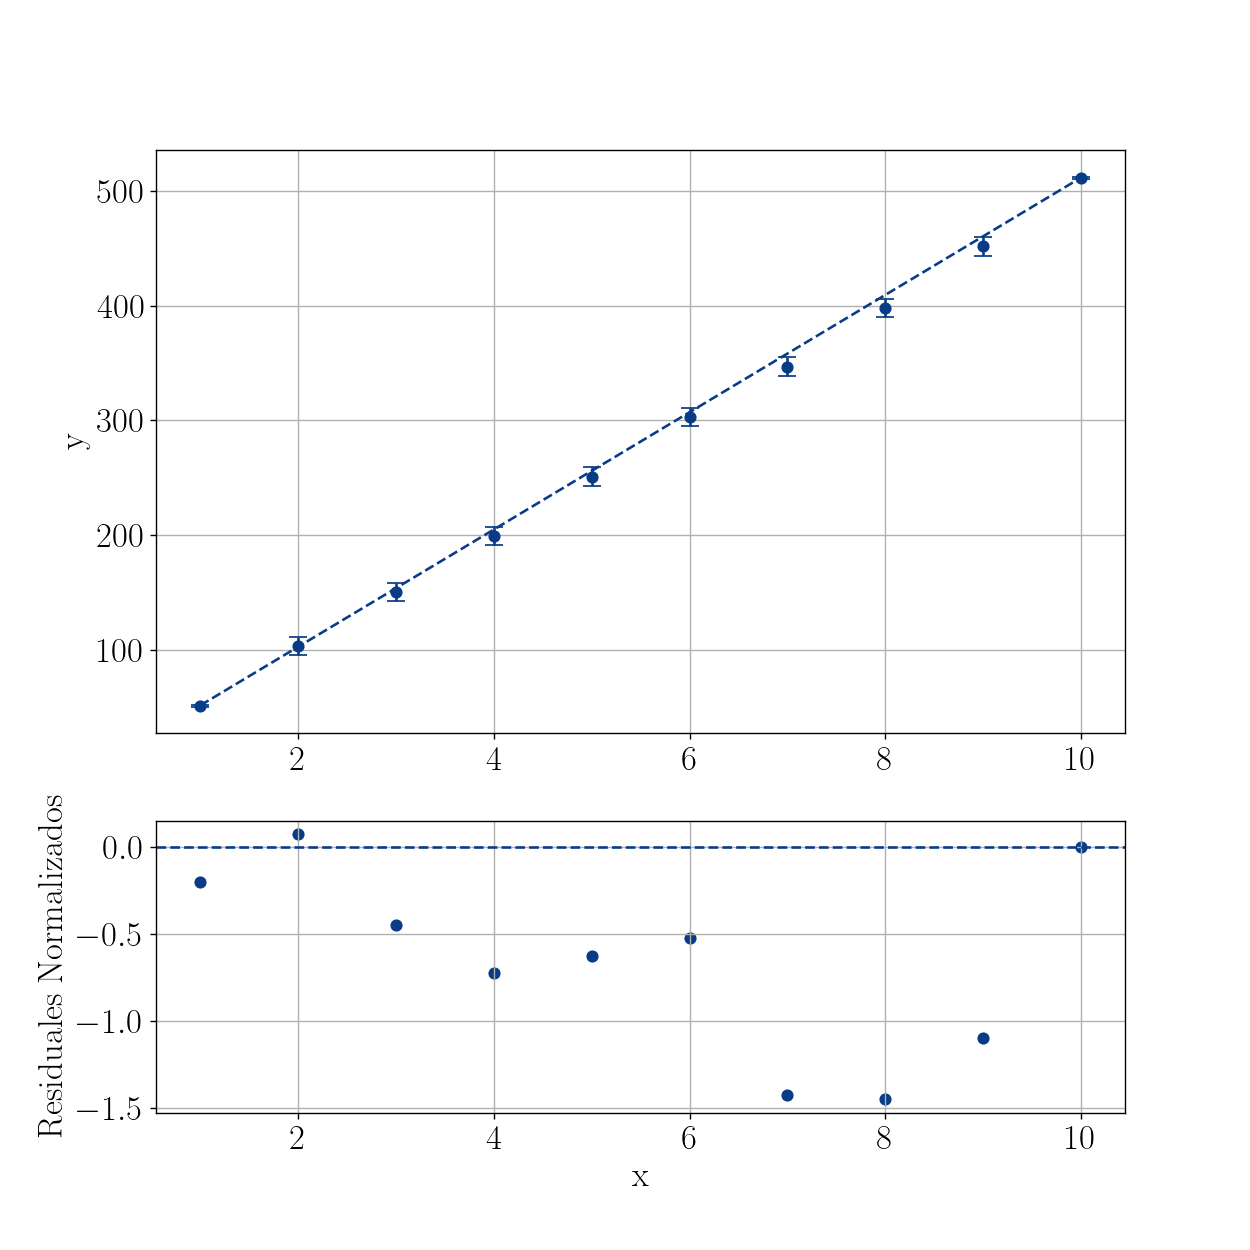

In [263]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(x, y, yerr = y_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(x_, y_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"y")
axis[0].grid(True)

axis[1].set_xlabel(r"x")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(x, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

In [264]:
display(Markdown("El valor obtenido para la pendiente es de ${} \pm {}$, mientras que para el intercepto es de ${} \pm {}$.".format(Gradient[0], Gradient[1], Intercept[0], Intercept[1])))

El valor obtenido para la pendiente es de $51.2 \pm 0.2$, mientras que para el intercepto es de $-0.0 \pm 1.0$.

En este caso final, el comportamiento de los residuales genera valores mucho menores que en los demás casos. Al conocer con una incertidumbre más baja los puntos extremos, estos poseen un peso mucho más grande en el cálculo del ajuste, por lo que la tendencia lineal es mucho más apreciable.

> **Capítulo #8: Hypothesis Testing.**

---

**(8.2) Confidence limits and $\chi_{\nu}^{2}$:** After performing a fit with $10$ degrees of freedom the value of $\chi^{2}_{\text{min}}$ is found to be $15.9$. Calculate **(a)** the value of $\chi_{\nu}^{2}$, and **(b)** the probability of obtaining a value of $\chi^{2}_{\text{min}}$ equal to this value or larger given the degrees of freedom. In another fit with $100$ degrees of freedom, the value of $\chi^{2}_{\text{min}}$ is $159$. Calculate **(c)** the value of $\chi_{\nu}^{2}$, and **(d)** the probability of obtaining a value of $\chi^{2}_{\text{min}}$ equal to this value or larger given the degrees of freedom. Comment on the differences between the values obtained in part **(b)** and **(d)**.

---

Para el primero de los casos descritos, $\chi^{2}_{\text{min}} = 15.9$, dados $10$ grados de libertad, el valor de $\chi^{2}_{\nu}$ es de:

$$\chi^{2}_{\nu} = \frac{15.9}{10} = 1.59$$

Para determinar la probabilidad de obtener un valor de $\chi^{2}_{\text{min}}$ mayor o igual a el encontrado se hará uso de un recurso de la librería de scipy especualizada en dicho cálculo:

In [265]:
valor_p = chi2.sf(15.9, 10)
display(Markdown("La probabilidad de obtener un valor mayor o igual será de, aproximadamente ${} \%$.".format(np.round(np.round(valor_p, 3)*100, 2))))

La probabilidad de obtener un valor mayor o igual será de, aproximadamente $10.3 \%$.

Para el segundo caso, donde $\chi^{2}_{\text{min}} = 159$, dados $100$ grados de libertad, el valor de $\chi^{2}_{\nu}$ es de:

$$\chi^{2}_{\nu} = \frac{159}{100} = 1.59$$

Como se logra apreciar, es el mismo que el anterior. No obstante, existe un cambio en la determinación de su probabilidad:

In [266]:
valor_p = chi2.sf(159, 100)
display(Markdown("La probabilidad de obtener un valor mayor o igual será de, aproximadamente ${} \%$.".format(np.round(np.round(valor_p, 4)*100, 4))))

La probabilidad de obtener un valor mayor o igual será de, aproximadamente $0.02 \%$.

Las discrepancias entre las probabilidades se deben a que, en presencia de un número elevado de grados de libertad, el comportamiento de la distribución asociada a $\chi^{2}$ es más similar a una distribución Gaussiana, por lo que, a valores elevados del $\chi^{2}_{\text{min}}$, menor será la posibilidad de encontrar valores aún más elevados.

---

**(8.5) Is the temporal distribution of goals in a footbal game uniform?:** In September $2009$, $101$ goals were scored in the English Premier League. A breakdown of the observed number of goals, $O_{i}$, during nine equal-duration time intervals is given below. Test the hypothesis that there is no preferential time during the game at which goals are scored, i.e. that the time distribution of goals is uniform.

**(i)** Assuming a uniform distribution, calculate the expected number of goals per interval, $E_{i}$.

**(ii)** Show that $E_{i} > 5$ for all bins, and hence there is no need to combine sequential bins. 

**(iii)** Calculate $\chi^{2}$ from the formula $\chi^{2} = \sum_{i = 1}^{9} (O_{i} - E_{i})^{2}/E_{i}$. 

**(iv)** Calculate the number of degrees of freedom. 

**(v)** Are the data consistent with the hypothesis of a uniform distribution?

In [289]:
Min_Interval = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 90)]
Goals = np.array([6, 11, 8, 8, 14, 12, 11, 12, 19])
Expected = np.ones_like(Goals)*(101/9)

Dada una distribución uniforme de información, el valor de goles por intervalo será:

$$E_{i} = \frac{101}{9} \approx 11.22 > 5$$

El número de grados de libertad del se determina con el número de intervalos. En este caso, $\nu = 9 - 1 = 8$. Partiendo de esto, el valor de $\chi^{2}$ será:

In [292]:
Chi = ChiSquaredDiscrete(Goals, Expected)
Chi_Critico = chi2.ppf(1 - 0.05, 8)
Chi, Chi_Critico

(10.475247524752476, 15.50731305586545)

Como se logra apreciar, el valor de $\chi^{2} \approx 10.48$ es considerablemente menor que $\chi^{2}_{\text{crit}} \approx 15.51$, lo que sugiere que es probable que los goles se encuentren distribuidos uniformemente, más no lo afirma.

**(8.7) Is a dice fair?:** A dice was thrown $100$ times, and the number of times each face landed up is given in page $119$. If the dice is fair, the expected number of occurrences would be the same for each number. Test the hypothesis that the dice is fair.

In [269]:
Face_values = np.array([1, 2, 3, 4, 5, 6])
Dice_values = np.array([17, 21, 14, 13, 16, 19])

Para este caso discreto, el valor de grados de libertad será el número de casos posibles menos una unidad, en este caso $\nu = 6 -1 = 5$. Por otro lado, los valores esperados para cada dado son de $1/6$, por lo que ya tenemos la información necesaria para calcular $\chi^{2}$ y su valor crítico a partir del cual la hipótesis se consideraría errónea:

In [287]:
Dice_expected = np.ones_like(Dice_values)*(100/6)
Chi = ChiSquaredDiscrete(Dice_values, Dice_expected)
Chi_Critico = chi2.ppf(1 - 0.05, 5)
Chi, Chi_Critico

(2.7199999999999998, 11.070497693516351)

Dado que el valor de $\chi^{2} \approx 2.72$ es mucho menor a $\chi^{2}_{\text{crit}} \approx 11.07$, podemos afirmar que la hipotesis se encuentra en un régimen justo, al estar por debajo del umbral establecido.

**(8.8) Is a straight line a good fit to the data?:**  Use the data tabulated in Exercises (6.5) and (7.8) and the best-fit straight line intercepts and gradients to calculate $\chi^{2}$ for the fits. How many degrees of freedom are there for these fits? Is it fair to conclude that the data are well fit by a straight line for these cases?


In [270]:
Concentration = np.array([0.025, 0.05, 0.075, 0.100, 0.125, 0.150, 0.175])
angle = np.array([10.7, 21.6, 32.4, 43.1, 53.9, 64.9, 75.4])
a_Error = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Gradient, Intercept = Parameters(Concentration, angle, a_Error)
Gradient = Error(Gradient[0], Gradient[1])
Intercept = Error(Intercept[0], Intercept[1])

In [271]:
NormRes = Residuals(Concentration, angle, a_Error, Gradient[0], Intercept[0])
Concentration_ = np.linspace(min(Concentration), max(Concentration), 100)
angle_ = Linear(Concentration_, Gradient[0], Intercept[0])

<IPython.core.display.Javascript object>


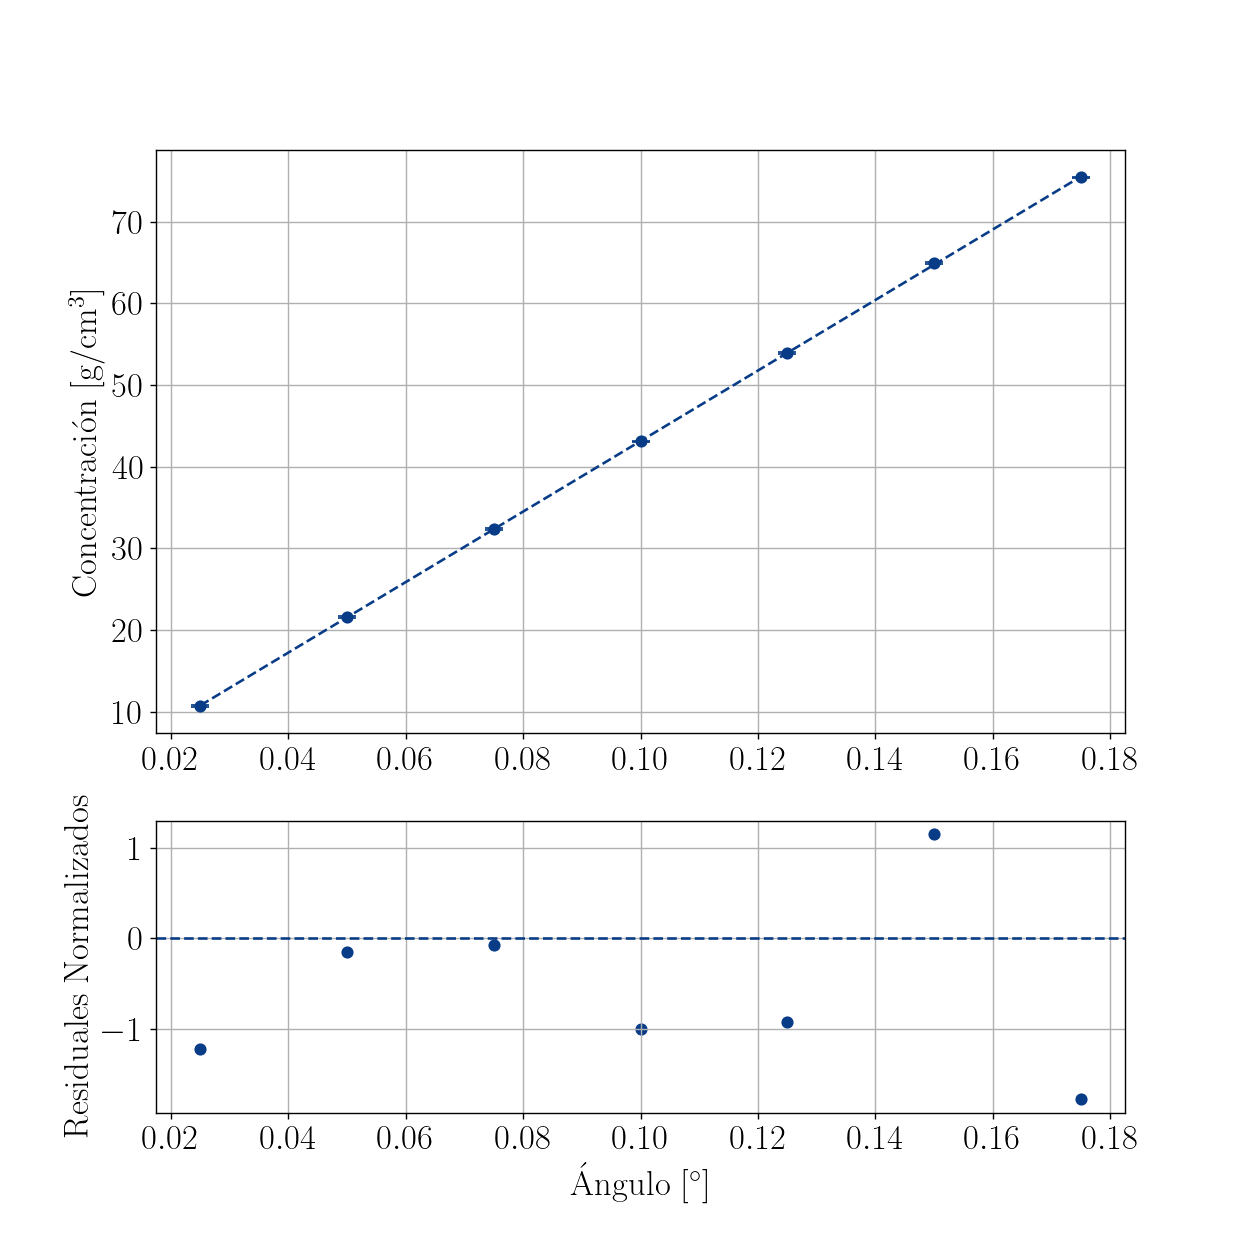

In [272]:
figure, axis = plt.subplots(2, 1, figsize = (10, 10), gridspec_kw = {"height_ratios": [2, 1]})
axis[0].errorbar(Concentration, angle, yerr = a_Error, color = "#083c87", capsize = 5, fmt = "o")
axis[0].plot(Concentration_, angle_, color = "#083c87", linestyle = "--")
axis[0].set_ylabel(r"Concentración [g/cm$^3$]")
axis[0].grid(True)

axis[1].set_xlabel(r"Ángulo [$^\circ$]")
axis[1].set_ylabel(r"Residuales Normalizados")
axis[1].scatter(Concentration, NormRes, color = "#083c87")
axis[1].axhline(0, color = "#083c87", linestyle = "--")
axis[1].grid(True)

Chi_7 = ChiSquared(Concentration, angle, a_Error, Gradient[0], Intercept[0])

In [273]:
display(Markdown("Para este caso particular, el valor de $\chi^2$ es de {}, mientras que el número de grados de libertad es de {}.".format(Chi_7, len(Concentration) - 1)))

Para este caso particular, el valor de $\chi^2$ es de 0.5577500000000268, mientras que el número de grados de libertad es de 6.

Para determinar si es un buen ajuste o no, es necesario calcular el valor-p del conjunto de datos:

In [274]:
display(Markdown("El valor obtendio del p-value es de {}. Como es mucho mayor a 0.05, el modelo se ajusta bien a los datos.".format(chi2.sf(Chi_7, 6))))

El valor obtendio del p-value es de 0.9970631267101756. Como es mucho mayor a 0.05, el modelo se ajusta bien a los datos.

Para el caso del ejercicio (6.5), el valor-p del conjunto de datos es:

In [278]:
display(Markdown("El valor obtendio del p-value es de {}. Como es mucho mayor a 0.05, el modelo se ajusta bien a los datos. No obstente, resulta algo contradictorio al observar los residuales normalizados, los cuales presentan una tendencia casi cúbica.".format(chi2.sf(Chi_6, 10))))

El valor obtendio del p-value es de 0.9999961204893729. Como es mucho mayor a 0.05, el modelo se ajusta bien a los datos. No obstente, resulta algo contradictorio al observar los residuales normalizados, los cuales presentan una tendencia casi cúbica.